In [155]:
# Import required libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from config import db_config
from plotly.subplots import make_subplots
import warnings
import ipywidgets as widgets
from IPython.display import display
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc


# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

# Set plotting style (using default instead of seaborn-v0_8 to avoid crash)
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [156]:
# Establish connection
connection = mysql.connector.connect(
    host=db_config["host"],
    user=db_config["user"],
    password=db_config["password"],
    database=db_config["database"]
)
cursor = connection.cursor()

In [157]:
teams_dict = {
    'team_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 46, 47, 48, 49, 52, 53, 54, 55, 56, 59, 68],
    'team_name': ['New Jersey Devils', 'New York Islanders', 'New York Rangers', 'Philadelphia Flyers', 'Pittsburgh Penguins', 'Boston Bruins', 'Buffalo Sabres', 'Montreal Canadiens', 'Ottawa Senators', 'Toronto Maple Leafs', 'Atlanta Thrashers', 'Carolina Hurricanes', 'Florida Panthers', 'Tampa Bay Lightning', 'Washington Capitals', 'Chicago Blackhawks', 'Detroit Red Wings', 'Nashville Predators', 'St Louis Blues', 'Calgary Flames', 'Colorado Avalanche', 'Edmonton Oilers', 'Vancouver Canucks', 'Anaheim Ducks', 'Dallas Stars', 'Los Angeles Kings', 'Pheonix Coyotes', 'San Jose Sharks', 'Columbus Blue Jackets', 'Minnesota Wild', 'Minnesota North Stars', 'Quebec Nordique', 'Winnipeg Jets (1979)', 'Hartford Whalers', 'Colorado Rockies', 'Oakland Seals', 'Atlanta Flames', 'Kansas City Scouts', 'Cleveland Barons', 'Winnipeg Jets', 'Arizona Coyotes', 'Vegas Golden Knights', 'Seattle Kraken', 'California Golden Seals', 'Utah Hockey Club', 'Utah Mammoth'],
    'team_abbreviation': ['NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'BOS', 'BUF', 'MTL', 'OTT', 'TOR', 'ATL', 'CAR', 'FLA', 'TBL', 'WSH', 'CHI', 'DET', 'NSH', 'STL', 'CGY', 'COL', 'EDM', 'VAN', 'ANA', 'DAL', 'LAK', 'PHX', 'SJS', 'CBJ', 'MIN', 'MNS', 'QUE', 'WIN', 'HFD', 'CLR', 'OAK', 'AFM', 'KCS', 'CLE', 'WPG', 'ARI', 'VGK', 'SEA', 'CGS', 'UTA', 'UTA']
}

In [158]:
cursor.execute('''
    SELECT * FROM players_season
''')

players = cursor.fetchall()

headers = [col[0] for col in cursor.description]    # column names
df = pd.DataFrame(players, columns=headers)

df = df.sort_values(["player_id", "season_id"])

players_df = df.merge(
    df,
    on="player_id",
    suffixes=("_prev", "_curr")
)

#get age from players table
cursor.execute('''
    SELECT player_id, birth_date FROM players
''')

players_birth = cursor.fetchall()

headers = [col[0] for col in cursor.description]    # column names
birth_df = pd.DataFrame(players_birth, columns=headers)

#merge tables on player_id
players_df = players_df.merge(
    birth_df,
    on="player_id",
)




In [159]:
players_df['season_year_prev'] = pd.to_numeric(players_df['season_id_prev'].astype(str).str[:4], errors='coerce')
players_df['season_year_curr'] = pd.to_numeric(players_df['season_id_curr'].astype(str).str[:4], errors='coerce')

# Keep only consecutive seasons
players_df = players_df[players_df['season_year_curr'] == players_df['season_year_prev'] + 1]

#start at season_id_prev as 19971998 to ensure we have prior season data
players_df = players_df[players_df['season_id_prev'] >= 19971998]

#take birth_date and convert to age at start of current season (assume season starts Oct 1 of season_year_curr), date format YYYY-MM-DD
players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], errors='coerce')
players_df['season_start_date'] = pd.to_datetime(players_df['season_year_curr'].astype(str) + '-10-01', errors='coerce')
players_df['age_curr'] = (players_df['season_start_date'] - players_df['birth_date']).dt.days / 365.25

# Features from previous season
# assists, ev_goals, ev_points, faceoff_win_pct, game_winning_goals, games_played, goals, ot_goals, penalty_minutes, plus_minus, points_per_game, 
# position_code, pp_goals, pp_points, season_id, sh_goals, sh_points, shooting_percentage, shoots_catches, shots, time_on_ice_per_game
features = [
    "assists_prev", "ev_goals_prev", "ev_points_prev", "game_winning_goals_prev", "games_played_prev", "goals_prev", "ot_goals_prev", "penalty_minutes_prev", "plus_minus_prev", "points_per_game_prev", 
    "pp_goals_prev", "pp_points_prev", "sh_goals_prev", "sh_points_prev", "shooting_percentage_prev", "shots_prev", "time_on_ice_per_game_prev", "season_year_prev", "age_curr"
]


Number of rows with any missing feature values: 331


,assists_prev,ev_goals_prev,ev_points_prev,faceoff_win_pct_prev,game_winning_goals_prev,games_played_prev,goals_prev,last_name_prev,ot_goals_prev,penalty_minutes_prev,player_id,plus_minus_prev,points_prev,points_per_game_prev,position_code_prev,pp_goals_prev,pp_points_prev,season_id_prev,sh_goals_prev,sh_points_prev,shooting_percentage_prev,shoots_catches_prev,shots_prev,skater_full_name_prev,team_abbreviations_prev,time_on_ice_per_game_prev,assists_curr,ev_goals_curr,ev_points_curr,faceoff_win_pct_curr,game_winning_goals_curr,games_played_curr,goals_curr,last_name_curr,ot_goals_curr,penalty_minutes_curr,plus_minus_curr,points_curr,points_per_game_curr,position_code_curr,pp_goals_curr,pp_points_curr,season_id_curr,sh_goals_curr,sh_points_curr,shooting_percentage_curr,shoots_catches_curr,shots_curr,skater_full_name_curr,team_abbreviations_curr,time_on_ice_per_game_curr,birth_date,season_year_prev,season_year_curr,season_start_date,age_curr
111748,0,0.0,0.0,0.0,0,1,0,Janssens,0,2,8448225,0.0,0,0.0,C,0.0,0.0,19971998,0.0,0.0,NaN,L,0.0,Mark Janssens,PHX,492.000,0,1.0,1.0,0.57912,0,60,1,Janssens,0,65,-11.0,1,0.01666,C,0.0,0.0,19981999,0.0,0.0,0.03703,L,27.0,Mark Janssens,CHI,497.433,1968-05-19,1997,1998,1998-10-01,30.368241
119395,0,0.0,0.0,NaN,0,3,0,Khristich,0,0,8448484,0.0,0,0.0,R,0.0,0.0,20002001,0.0,0.0,NaN,R,0.0,Dmitri Khristich,WSH,410.333,12,6.0,16.0,0.46376,2,61,9,Khristich,0,12,2.0,21,0.34426,R,3.0,5.0,20012002,0.0,0.0,0.16666,R,54.0,Dmitri Khristich,WSH,839.885,1969-07-23,2000,2001,2001-10-01,32.191650
156066,0,0.0,0.0,NaN,0,1,0,McKenzie,0,0,8449477,0.0,0,0.0,L,0.0,0.0,19992000,0.0,0.0,NaN,L,0.0,Jim McKenzie,WSH,17.000,2,2.0,4.0,NaN,0,56,2,McKenzie,0,121,1.0,4,0.07142,L,0.0,0.0,20002001,0.0,0.0,0.06060,L,33.0,Jim McKenzie,NJD,468.553,1969-11-03,1999,2000,2000-10-01,30.910335
219739,0,0.0,0.0,NaN,0,2,0,Zettler,0,2,8452695,-2.0,0,0.0,D,0.0,0.0,19981999,0.0,0.0,NaN,L,0.0,Rob Zettler,NSH,976.500,2,0.0,2.0,NaN,0,17,0,Zettler,0,21,-3.0,2,0.11764,D,0.0,0.0,19992000,0.0,0.0,0.00000,L,19.0,Rob Zettler,WSH,901.647,1968-03-08,1998,1999,1999-10-01,31.564682
231479,0,0.0,0.0,NaN,0,1,0,Persson,0,0,8457661,0.0,0,0.0,D,0.0,0.0,19971998,0.0,0.0,NaN,L,0.0,Ricard Persson,STL,39.000,15,1.0,15.0,1.00000,0,67,1,Persson,0,111,3.0,16,0.23880,D,0.0,1.0,19981999,0.0,0.0,0.01562,L,64.0,Ricard Persson,STL,1224.480,1969-08-24,1997,1998,1998-10-01,29.103354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462146,0,0.0,0.0,NaN,0,1,0,Burke,0,0,8482250,0.0,0,0.0,C,0.0,0.0,20232024,0.0,0.0,NaN,R,0.0,Callahan Burke,CAR,426.000,0,1.0,1.0,1.00000,0,7,1,Burke,0,2,2.0,1,0.14285,C,0.0,0.0,20242025,0.0,0.0,0.08333,R,12.0,Callahan Burke,VGK,650.429,1997-03-19,2023,2024,2024-10-01,27.537303
462223,0,0.0,0.0,0.0,0,4,0,Heineman,0,0,8482476,2.0,0,0.0,L,0.0,0.0,20232024,0.0,0.0,NaN,L,0.0,Emil Heineman,MTL,597.250,8,8.0,14.0,0.20000,0,67,11,Heineman,0,20,-5.0,19,0.28358,L,3.0,5.0,20242025,0.0,0.0,0.16176,L,68.0,Emil Heineman,MTL,673.134,2001-11-16,2023,2024,2024-10-01,22.874743
462336,0,0.0,0.0,NaN,0,1,0,Duehr,0,0,8482652,0.0,0,0.0,R,0.0,0.0,20212022,0.0,0.0,NaN,R,0.0,Walker Duehr,CGY,527.000,4,7.0,11.0,0.14285,2,27,7,Duehr,0,4,0.0,11,0.40740,R,0.0,0.0,20222023,0.0,0.0,0.14893,R,47.0,Walker Duehr,CGY,611.778,1997-11-23,2021,2022,2022-10-01,24.854209
462586,0,0.0,0.0,NaN,0,1,0,Olausson,0,0,8482712,0.0,0,0.0,R,0.0,0.0,20222023,0.0,0.0,NaN,L,0.0,Oskar Olausson,COL,422.000,0,0.0,0.0,NaN,0,1,0,Olausson,0,0,0.0,0,0.00000,R,0.0,0.0,20232024,0.0,0.0,0.00000,L,2.0,Oskar Olausson,COL,710.000,2002-11-10,2022,2023,2023-10-01,20.889802



Missing counts by feature:
shooting_percentage_prev     331
ev_goals_prev                  0
assists_prev                   0
ev_points_prev                 0
game_winning_goals_prev        0
goals_prev                     0
games_played_prev              0
penalty_minutes_prev           0
plus_minus_prev                0
points_per_game_prev           0
ot_goals_prev                  0
pp_goals_prev                  0
pp_points_prev                 0
sh_goals_prev                  0
sh_points_prev                 0
shots_prev                     0
time_on_ice_per_game_prev      0
season_year_prev               0
age_curr                       0
dtype: int64


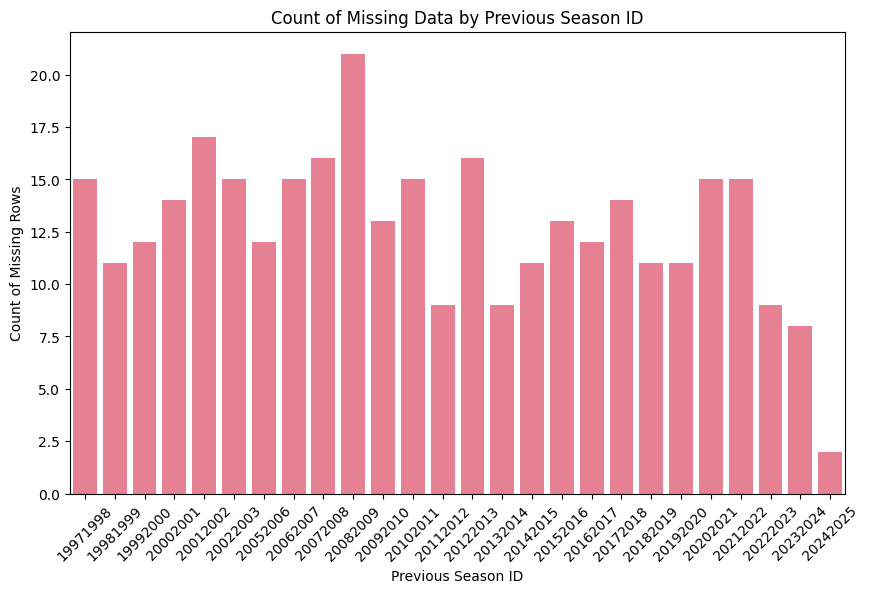

After dropping missing data, players_df shape: (18482, 56)


In [160]:

# Build a boolean mask from players_df[features] so the index lines up with players_df
mask = players_df[features].isnull().any(axis=1)

print("Number of rows with any missing feature values:", mask.sum())

# Show rows with missing features (aligned index)
missing_data = players_df.loc[mask]
display(missing_data)

# Quick per-feature missing counts (helpful for deciding imputation)
print("\nMissing counts by feature:")
print(players_df[features].isnull().sum().sort_values(ascending=False))

# Plot missing rows by previous season id (same as you had)
plt.figure(figsize=(10,6))
sns.countplot(x='season_id_prev', data=missing_data)
plt.title('Count of Missing Data by Previous Season ID')
plt.xlabel('Previous Season ID')
plt.ylabel('Count of Missing Rows')
plt.xticks(rotation=45)
plt.show()

# If you still want to drop rows with missing features:
players_df = players_df.dropna(subset=features)
print("After dropping missing data, players_df shape:", players_df.shape)

In [161]:
#drop assists_prev, ev_goals_prev, goals_prev
#players_df = players_df.drop(columns=['assists_prev', 'ev_goals_prev', 'goals_prev', 'sh_goals_prev', 'sh_points_prev', 'pp_goals_prev', 'season_year_prev'])
#remove from features
# features.remove('assists_prev')
# features.remove('ev_goals_prev')
# features.remove('goals_prev')
# features.remove('sh_goals_prev')
# features.remove('sh_points_prev')
# features.remove('pp_goals_prev')
# features.remove('season_year_prev')

#remove any players with less than 20 games played in previous season
players_df = players_df[players_df['games_played_prev'] >= 20]
#remove any players with 0 points per game in previous season
players_df = players_df[players_df['points_per_game_prev'] > 0]

In [162]:
#add interaction terms
players_df["ev_goals_x_shots"] = players_df["ev_goals_prev"] * players_df["shots_prev"]
features.append("ev_goals_x_shots")

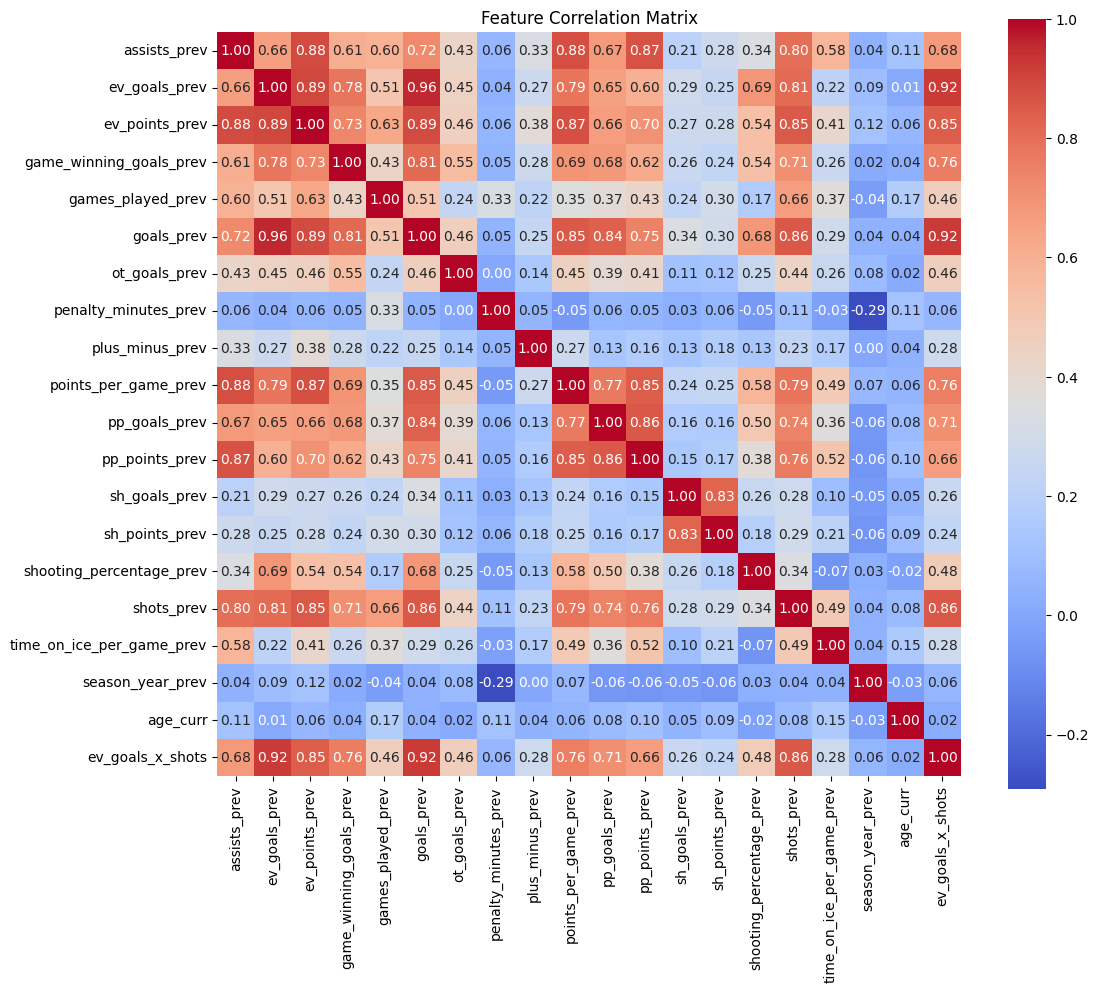

In [163]:
#check for coorrelation between features
corr_matrix = players_df[features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [164]:
X = players_df[features]
y = players_df["points_per_game_curr"]

In [165]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    players_df[features], 
    players_df["points_per_game_curr"], 
    test_size=0.2, 
    random_state=42
)

# Add intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit OLS
model = sm.OLS(y_train, X_train_const).fit()

train_cols = X_train_const.columns.tolist()

# Predict on test set
y_pred = model.predict(X_test_const)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test R²: {r2:.2f}, RMSE: {rmse:.3f}")

# Combine coefficients and p-values
coeffs = pd.DataFrame({
    "feature": model.params.index,
    "coefficient": model.params.values,
    "p_value": model.pvalues.values
}).sort_values(by="coefficient", ascending=False)

coeffs_formatted = coeffs.copy()
coeffs_formatted["coefficient"] = coeffs_formatted["coefficient"].map("{:.5f}".format)
coeffs_formatted["p_value"] = coeffs_formatted["p_value"].map("{:.5f}".format)

print(coeffs_formatted)

#R²: 0.61, RMSE: 0.178

Test R²: 0.63, RMSE: 0.176
                      feature coefficient  p_value
10       points_per_game_prev     0.71544  0.00000
7               ot_goals_prev     0.01400  0.00001
4     game_winning_goals_prev     0.00410  0.00254
13              sh_goals_prev     0.00373  0.13699
12             pp_points_prev     0.00237  0.00126
6                  goals_prev     0.00234  0.00053
2               ev_goals_prev     0.00191  0.14259
16                 shots_prev     0.00051  0.00000
3              ev_points_prev     0.00047  0.52513
18           season_year_prev     0.00037  0.07811
17  time_on_ice_per_game_prev     0.00001  0.18357
20           ev_goals_x_shots    -0.00001  0.00077
8        penalty_minutes_prev    -0.00014  0.00429
9             plus_minus_prev    -0.00037  0.01284
5           games_played_prev    -0.00042  0.03097
1                assists_prev    -0.00123  0.07591
14             sh_points_prev    -0.00173  0.30541
11              pp_goals_prev    -0.00330  0.00707
19  

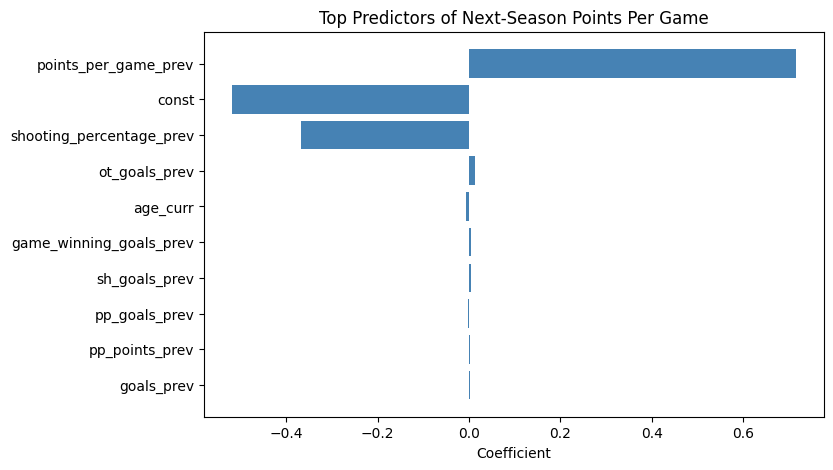

In [166]:
top_coeffs = coeffs.copy()
top_coeffs["coefficient"] = top_coeffs["coefficient"].astype(float)
top_coeffs = top_coeffs.reindex(top_coeffs["coefficient"].abs().sort_values(ascending=False).index)[:10]

plt.figure(figsize=(8,5))
plt.barh(top_coeffs["feature"], top_coeffs["coefficient"], color="steelblue")
plt.xlabel("Coefficient")
plt.title("Top Predictors of Next-Season Points Per Game")
plt.gca().invert_yaxis()
plt.show()

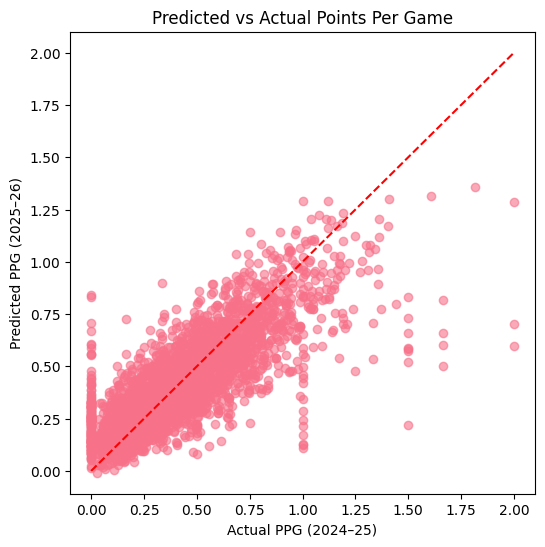

In [167]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PPG (2024–25)")
plt.ylabel("Predicted PPG (2025–26)")
plt.title("Predicted vs Actual Points Per Game")
plt.show()

In [168]:
#select a couple players to compare actual vs predicted
sample_players = X_test.sample(5, random_state=42)

sample_players_const = sm.add_constant(sample_players)

sample_predictions = model.predict(sample_players_const)
print("Sample Player Predictions:")
for player_id, actual, predicted in zip(sample_players.index, y_test.loc[sample_players.index], sample_predictions):
    player_name = players_df.loc[player_id, 'last_name_prev']
    print(f"Player ID: {players_df.loc[player_id, 'player_id']}, Name: {player_name}, Actual PPG: {actual:.3f}, Predicted PPG: {predicted:.3f}")
# Combine coefficients and p-values
coeffs = pd.DataFrame({
    "feature": model.params.index,
    "coefficient": model.params.values,
    "p_value": model.pvalues.values
}).sort_values(by="coefficient", ascending=False)


Sample Player Predictions:
Player ID: 8469492, Name: Tyutin, Actual PPG: 0.338, Predicted PPG: 0.425
Player ID: 8476454, Name: Nugent-Hopkins, Actual PPG: 0.700, Predicted PPG: 0.565
Player ID: 8478133, Name: Evans, Actual PPG: 0.341, Predicted PPG: 0.312
Player ID: 8459574, Name: Tucker, Actual PPG: 0.254, Predicted PPG: 0.426
Player ID: 8459442, Name: Koivu, Actual PPG: 0.514, Predicted PPG: 0.512


In [169]:
#for all players in players_df with the most recent season_id_prev as 20242025, predict their points_per_game_curr of the upcoming season

upcoming_season_players = players_df[players_df['season_id_prev'] == 20242025]
upcoming_season_X = upcoming_season_players[features]
upcoming_season_X_const = sm.add_constant(upcoming_season_X, has_constant='add')

upcoming_season_predictions = model.predict(upcoming_season_X_const)
print("Upcoming Season Predictions:")
for player_id, predicted in zip(upcoming_season_players.index, upcoming_season_predictions):
    player_name = upcoming_season_players.loc[player_id, 'last_name_prev']
    print(f"Player ID: {upcoming_season_players.loc[player_id, 'player_id']}, Name: {player_name}, Predicted PPG (2025–26): {predicted:.3f}")



Upcoming Season Predictions:
Player ID: 8470613, Name: Burns, Predicted PPG (2025–26): 0.309
Player ID: 8471214, Name: Ovechkin, Predicted PPG (2025–26): 0.928
Player ID: 8471215, Name: Malkin, Predicted PPG (2025–26): 0.603
Player ID: 8471675, Name: Crosby, Predicted PPG (2025–26): 1.014
Player ID: 8471685, Name: Kopitar, Predicted PPG (2025–26): 0.680
Player ID: 8471724, Name: Letang, Predicted PPG (2025–26): 0.367
Player ID: 8471817, Name: Reaves, Predicted PPG (2025–26): 0.041
Player ID: 8473419, Name: Marchand, Predicted PPG (2025–26): 0.654
Player ID: 8473422, Name: Foligno, Predicted PPG (2025–26): 0.354
Player ID: 8473507, Name: Petry, Predicted PPG (2025–26): 0.147
Player ID: 8473512, Name: Giroux, Predicted PPG (2025–26): 0.524
Player ID: 8473533, Name: Staal, Predicted PPG (2025–26): 0.357
Player ID: 8473986, Name: Killorn, Predicted PPG (2025–26): 0.417
Player ID: 8474013, Name: Cole, Predicted PPG (2025–26): 0.155
Player ID: 8474102, Name: Perron, Predicted PPG (2025–26): 

In [170]:
#this doesn't account for playing on multiple teams (those are 2 different rows)
#biased against top players for decreases
#biased for players who played few games previously

upcoming_season_players = upcoming_season_players.copy()
upcoming_season_players['predicted_points_per_game_curr'] = upcoming_season_predictions
#remove players with games_played_prev less than 20
upcoming_season_players = upcoming_season_players[upcoming_season_players['games_played_prev'] >= 20]
upcoming_season_players['points_per_game_change'] = upcoming_season_players['predicted_points_per_game_curr'] - upcoming_season_players['points_per_game_prev']
top_increases = upcoming_season_players.nlargest(10, 'points_per_game_change')
top_decreases = upcoming_season_players.nsmallest(10, 'points_per_game_change')

print("Top 10 Players with Biggest Predicted PPG Increases for 2025–26:")
for idx, row in top_increases.iterrows():
    print(f"Player ID: {row['player_id']}, Name: {row['last_name_prev']}, Previous PPG: {row['points_per_game_prev']:.3f}, Predicted PPG (2025–26): {row['predicted_points_per_game_curr']:.3f}, Change: {row['points_per_game_change']:.3f}")

print("\nTop 10 Players with Biggest Predicted PPG Decreases for 2025–26:")
for idx, row in top_decreases.iterrows():
    print(f"Player ID: {row['player_id']}, Name: {row['last_name_prev']}, Previous PPG: {row['points_per_game_prev']:.3f}, Predicted PPG (2025–26): {row['predicted_points_per_game_curr']:.3f}, Change: {row['points_per_game_change']:.3f}")

Top 10 Players with Biggest Predicted PPG Increases for 2025–26:
Player ID: 8483468, Name: Kulich, Previous PPG: 0.387, Predicted PPG (2025–26): 0.462, Change: 0.074
Player ID: 8482775, Name: Kapanen, Previous PPG: 0.143, Predicted PPG (2025–26): 0.213, Change: 0.070
Player ID: 8482176, Name: Kaiser, Previous PPG: 0.140, Predicted PPG (2025–26): 0.208, Change: 0.068
Player ID: 8483495, Name: Nemec, Previous PPG: 0.194, Predicted PPG (2025–26): 0.261, Change: 0.067
Player ID: 8478468, Name: Lauzon, Previous PPG: 0.036, Predicted PPG (2025–26): 0.101, Change: 0.065
Player ID: 8483678, Name: Pettersson, Previous PPG: 0.107, Predicted PPG (2025–26): 0.172, Change: 0.065
Player ID: 8482964, Name: Xhekaj, Previous PPG: 0.082, Predicted PPG (2025–26): 0.145, Change: 0.063
Player ID: 8481604, Name: Dorofeyev, Previous PPG: 0.600, Predicted PPG (2025–26): 0.662, Change: 0.062
Player ID: 8480878, Name: Lundkvist, Previous PPG: 0.128, Predicted PPG (2025–26): 0.189, Change: 0.061
Player ID: 84828

In [171]:
expected = list(model.params.index)
print("Expected columns (model params):", expected)

# what you currently have for upcoming season (without constant)
print("Upcoming season feature columns:", list(upcoming_season_X_const.columns))


Expected columns (model params): ['const', 'assists_prev', 'ev_goals_prev', 'ev_points_prev', 'game_winning_goals_prev', 'games_played_prev', 'goals_prev', 'ot_goals_prev', 'penalty_minutes_prev', 'plus_minus_prev', 'points_per_game_prev', 'pp_goals_prev', 'pp_points_prev', 'sh_goals_prev', 'sh_points_prev', 'shooting_percentage_prev', 'shots_prev', 'time_on_ice_per_game_prev', 'season_year_prev', 'age_curr', 'ev_goals_x_shots']
Upcoming season feature columns: ['const', 'assists_prev', 'ev_goals_prev', 'ev_points_prev', 'game_winning_goals_prev', 'games_played_prev', 'goals_prev', 'ot_goals_prev', 'penalty_minutes_prev', 'plus_minus_prev', 'points_per_game_prev', 'pp_goals_prev', 'pp_points_prev', 'sh_goals_prev', 'sh_points_prev', 'shooting_percentage_prev', 'shots_prev', 'time_on_ice_per_game_prev', 'season_year_prev', 'age_curr', 'ev_goals_x_shots']
